In [6]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
import joblib

QRELS_FILE = "../qrels.txt"
QUERY_URL = "http://localhost:8983/solr/books/select?defType=edismax&indent=true&q.op=OR&q=novel%20AND%20post-apocalyptic&qf=book_title%20reviews.text%20reviews.summary%20description%20categories&rows=40&useParams="


"""
q = novel AND post-apocalyptic
q.op = or

defType = edismax
qf = book_title reviews.text reviews.summary description categories
"""


# Read qrels to extract relevant documents
relevant = list(map(lambda el: int(el.strip()), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']

In [7]:
print([1 if int(doc['book_id']) in relevant else 0 for doc in results])

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]


In [8]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['book_id'] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['book_id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
                  [
                      [evaluation_metrics[m], calculate_metric(m, results, relevant)]
                      for m in evaluation_metrics
                  ]
                  )

with open('results.tex','w') as tf:
    tf.write(df.to_latex())
with open('results.csv','w') as tf:
    tf.write(df.to_csv())


[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
[(0.02702702702702703, 1.0), (0.05405405405405406, 1.0), (0.05405405405405406, 0.875), (0.08108108108108109, 0.875), (0.10810810810810811, 0.875), (0.13513513513513514, 0.875), (0.16216216216216217, 0.875), (0.1891891891891892, 0.875), (0.1891891891891892, 0.8461538461538461), (0.1891891891891892, 0.8461538461538461), (0.21621621621621623, 0.8461538461538461), (0.24324324324324326, 0.8461538461538461), (0.2702702702702703, 0.8461538461538461), (0.2972972972972973, 0.8461538461538461), (0.32432432432432434, 0.8461538461538461), (0.35135135135135137, 0.8461538461538461), (0.3783783783783784, 0.8461538461538461), (0.40540540540540543, 0.8461538461538461), (0.40540540540540543, 0.8461538461538461), (0.43243243243243246, 0.8461538461538461), (0.4594594594594595, 0.8461538461538461), (0.4864864864864865, 0.8461538461538461), (0.5135135135135135, 0.8461538461538461), (0.540

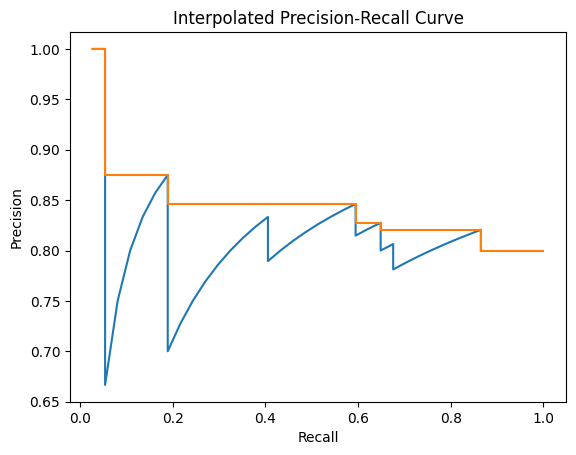

In [9]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc
        for doc in results[:idx+1]
        if doc['book_id'] in relevant
    ]) / (idx+1)
    for idx, _ in enumerate(results)
]

recall_values = [
    len([
        doc for doc in results[:idx+1]
        if doc['book_id'] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results)
]

plt.plot(recall_values, precision_values)
print([1 if doc['book_id'] in relevant else 0 for doc in results])
decreasing_max_precision = np.maximum.accumulate(precision_values[::-1])[::-1]
precision_recall_match = list(zip(recall_values, decreasing_max_precision))
print(precision_recall_match)
# if the last element of recall_values is not 1, add it

if recall_values[-1] != 1:
    precision_recall_match.append((1, precision_values[-1]))
# Plot precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Interpolated Precision-Recall Curve')
plt.plot(*zip(*precision_recall_match))
joblib.dump(precision_recall_match, 'base_system.joblib')
plt.savefig('precision_recall.pdf')
# plt.plot(recall_values, decreasing_max_precision)
